In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import lognorm
from arch import arch_model

In [4]:
df_price = pd.read_csv(r"SET 50 Historical Data (9).csv")

FileNotFoundError: [Errno 2] No such file or directory: 'SET 50 Historical Data (9).csv'

In [ ]:
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price = df_price.sort_values(by='Date').reset_index(drop=True)

In [ ]:
df_price['Date'] = pd.to_datetime(df_price['Date'])  
df_price.set_index('Date', inplace=True)
df_price['Price'] = df_price['Price'].str.replace(',', '', regex=False)
df_price['Price'] = pd.to_numeric(df_price['Price'], errors='coerce')

In [ ]:
file_path = r"SOMC Data SET Clear.xlsx"

# อ่านเฉพาะ Vol
df_vol = pd.read_excel(file_path, sheet_name="SET50 Volatility")

# อ่านเฉพาะ Zero Yield
df_rf = pd.read_excel(file_path, sheet_name="Zero Yield (Rf)")

# ตรวจสอบข้อมูล
print(df_vol.head())
print(df_rf.head())


   CALC_DATE SETL_DM_CODE   PROD_CODE  HIS_VLT
0   20200102         SD01  SET50_OPT   10.8110
1   20200103         SD01  SET50_OPT   10.4420
2   20200106         SD01  SET50_OPT   11.7821
3   20200107         SD01  SET50_OPT   12.1831
4   20200108         SD01  SET50_OPT   13.6843
   BIZ_DATE SOURCE_TYPE                            TIME       TTM     YIELD
0  20200102           A  2020-01-02T00:00:00</asof       0.076712  1.148501
1  20200102           A  2020-01-02T00:00:00</asof       0.249315  1.157958
2  20200102           A  2020-01-02T00:00:00</asof       0.498630  1.177817
3  20200102           A  2020-01-02T00:00:00</asof       1.000000  1.197676
4  20200102           A  2020-01-02T00:00:00</asof       2.000000  1.139669


In [ ]:
df_vol['CALC_DATE'] = pd.to_datetime(df_vol['CALC_DATE'], format='%Y%m%d')
df_vol.set_index('CALC_DATE', inplace=True)

df_rf['BIZ_DATE'] = pd.to_datetime(df_rf['BIZ_DATE'], format='%Y%m%d')
df_rf.set_index('BIZ_DATE', inplace=True)

print(df_vol.head())
print(df_rf.head())


           SETL_DM_CODE   PROD_CODE  HIS_VLT
CALC_DATE                                   
2020-01-02         SD01  SET50_OPT   10.8110
2020-01-03         SD01  SET50_OPT   10.4420
2020-01-06         SD01  SET50_OPT   11.7821
2020-01-07         SD01  SET50_OPT   12.1831
2020-01-08         SD01  SET50_OPT   13.6843
           SOURCE_TYPE                            TIME       TTM     YIELD
BIZ_DATE                                                                  
2020-01-02           A  2020-01-02T00:00:00</asof       0.076712  1.148501
2020-01-02           A  2020-01-02T00:00:00</asof       0.249315  1.157958
2020-01-02           A  2020-01-02T00:00:00</asof       0.498630  1.177817
2020-01-02           A  2020-01-02T00:00:00</asof       1.000000  1.197676
2020-01-02           A  2020-01-02T00:00:00</asof       2.000000  1.139669


In [ ]:
df_rf_fix = df_rf[df_rf['TTM'] == 1.0][['YIELD']]
print(df_vol)

           SETL_DM_CODE   PROD_CODE  HIS_VLT
CALC_DATE                                   
2020-01-02         SD01  SET50_OPT   10.8110
2020-01-03         SD01  SET50_OPT   10.4420
2020-01-06         SD01  SET50_OPT   11.7821
2020-01-07         SD01  SET50_OPT   12.1831
2020-01-08         SD01  SET50_OPT   13.6843
...                 ...         ...      ...
2025-03-25         SD01  SET50_OPT   19.9875
2025-03-26         SD01  SET50_OPT   19.6598
2025-03-27         SD01  SET50_OPT   19.2603
2025-03-28         SD01  SET50_OPT   19.1930
2025-03-31         SD01  SET50_OPT   19.3716

[1274 rows x 3 columns]


In [ ]:
prices = df_price['Price']
returns = prices.pct_change().dropna()
returns = returns.to_frame(name='Return')  

In [ ]:
returns.describe()

,Return
count,2525.000000
mean,-0.000044
std,0.010461
min,-0.116964
25%,-0.004961
50%,0.000021
75%,0.004884
max,0.092660


In [ ]:
valid_dates = df_vol.dropna().index.intersection(df_rf_fix.dropna().index)

# เช็กว่ามีวันที่ที่ซ้อนกันจริงไหม
if len(valid_dates) > 0:
    last_valid_date = valid_dates.max()

    # หา S0 จาก df_price
    if last_valid_date in df_price.index:
        S0 = float(df_price.loc[last_valid_date, 'Price'])
    else:
        # หาใกล้สุดก่อนหน้า (forward-fill)
        S0 = float(df_price['Price'].ffill().loc[:last_valid_date].iloc[-1])

    # ใช้ค่า volatility และ rf จากวันสุดท้ายที่มีข้อมูลพร้อมกัน
    sigma = float(df_vol.loc[last_valid_date, 'HIS_VLT'])
    r = float(df_rf_fix.loc[last_valid_date, 'YIELD'])

    print(f"📅 ใช้ข้อมูลวันที่: {last_valid_date}")
    print(f"🎯 S0 = {S0}, σ = {sigma}, r = {r}")

else:
    raise ValueError("❌ ไม่พบวันที่ที่ df_vol และ df_rf_fix มีข้อมูลพร้อมกันเลย")


📅 ใช้ข้อมูลวันที่: 2025-03-31 00:00:00
🎯 S0 = 739.77, σ = 19.3716, r = 1.820906


In [ ]:
#parameter
S0 = 764
n_period = 5
buffer = 0
sigma = 19.3716
cap = abs(returns['Return'].min()) + buffer
upper_factor = (1+cap)**n_period
lower_factor = (1-cap)**n_period
min_St = S0 *lower_factor
max_St = S0*upper_factor
step = 0.01
T = 5/252

In [ ]:
min_St = round(min_St,2)
max_St = round(max_St,2)

In [ ]:
min_St,max_St

(410.19, 1328.28)

In [ ]:
mu_ln = np.log(S0) + (r - 0.5 * (sigma/100)**2) * T
var_ln = (sigma/100)**2 * T

# เก็บผลลัพธ์
result = []

# For loop ไล่ราคาทีละ 0.01
price = min_St
while price <= max_St:
    pdf = (1 / (price * (sigma/100) * np.sqrt(2 * np.pi * T))) * np.exp(
        -((np.log(price) - mu_ln) ** 2) / (2 * var_ln)
    )
    result.append({'S_T': price, 'PDF': pdf})
    price = round(price + step, 2)  # ป้องกัน floating-point error
    

# สร้าง DataFrame
df_pdf = pd.DataFrame(result)


In [ ]:
df_pdf

,S_T,PDF
0,410.19,6.967995e-55
1,410.20,7.030620e-55
2,410.21,7.093803e-55
3,410.22,7.157551e-55
4,410.23,7.221868e-55
...,...,...
91805,1328.24,1.767274e-35
91806,1328.25,1.763406e-35
91807,1328.26,1.759548e-35
91808,1328.27,1.755697e-35


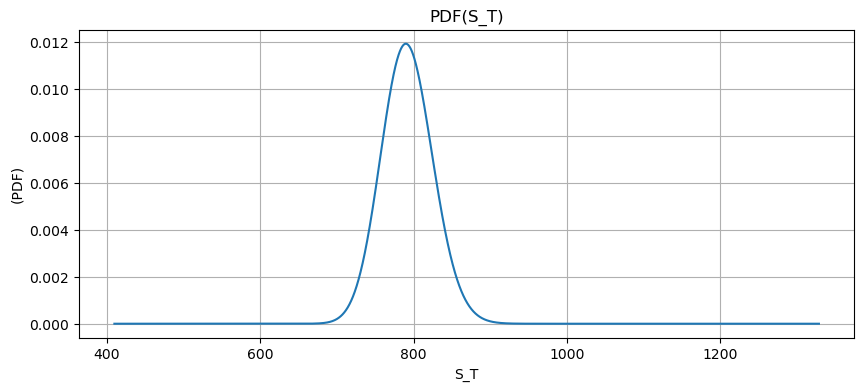

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df_pdf['S_T'], df_pdf['PDF'])
plt.title("PDF(S_T)")
plt.xlabel("S_T")
plt.ylabel("(PDF)")
plt.grid()
plt.show()

In [ ]:
area = df_pdf.query("S_T >= 750 and S_T <= 800")['PDF'].sum() * 0.01  # * step size
area


0.49924106862200335

In [ ]:
strike = 739
atm_band = 10
step = 0.1
lower_bound = strike - atm_band
upper_bound = strike + atm_band
prob_atm = df_pdf.query(f"S_T >= {lower_bound} and S_T <= {upper_bound}")['PDF'].sum() * step


print(f"📈 ความน่าจะเป็นที่ Call OTM  จะกลายเป็น ATM ภายใน 5 วัน: {prob_atm:.7%}")

📈 ความน่าจะเป็นที่ Call OTM  จะกลายเป็น ATM ภายใน 5 วัน: 156.5619195%


In [ ]:
step = df_pdf['S_T'].diff().dropna().mode()[0]

prob_atm = df_pdf.query(
    f"S_T >= {lower_bound} and S_T <= {upper_bound}"
)['PDF'].sum() * step
print(f"📈 ความน่าจะเป็นที่ Call OTM  จะกลายเป็น ATM ภายใน 5 วัน: {prob_atm:.7%}")

📈 ความน่าจะเป็นที่ Call OTM  จะกลายเป็น ATM ภายใน 5 วัน: 15.6561919%


In [ ]:
strike = 92
atm_band = 10
step = 0.1
lower_bound = strike - atm_band
upper_bound = strike + atm_band
prob_atm = df_pdf.query(f"S_T >= {lower_bound} and S_T <= {upper_bound}")['PDF'].sum() * step

print(f"📈 ความน่าจะเป็นที่ Call OTM จะกลายเป็น ATM ภายใน 5 วัน: {prob_atm:.4%}")

📈 ความน่าจะเป็นที่ Call OTM จะกลายเป็น ATM ภายใน 5 วัน: 0.0000%


In [ ]:
step = df_pdf['S_T'].diff().dropna().mode()[0]

prob_atm = df_pdf.query(
    f"S_T >= {lower_bound} and S_T <= {upper_bound}"
)['PDF'].sum() * step
print(f"📈 ความน่าจะเป็นที่ Call OTM  จะกลายเป็น ATM ภายใน 5 วัน: {prob_atm:.7%}")

📈 ความน่าจะเป็นที่ Call OTM  จะกลายเป็น ATM ภายใน 5 วัน: 0.0000000%


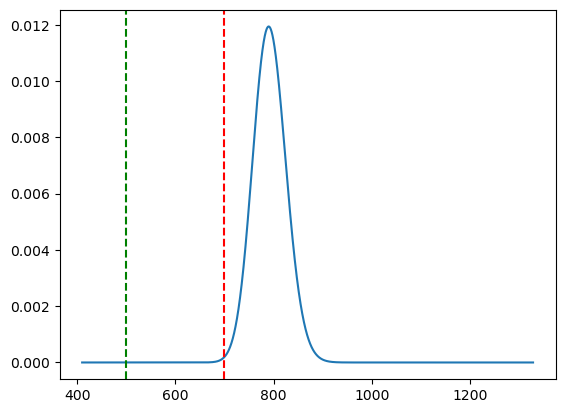

In [ ]:
plt.plot(df_pdf["S_T"], df_pdf["PDF"])
plt.axvline(700, color='red', linestyle='--')
plt.axvline(500, color='green', linestyle='--')


In [ ]:
expected_ST = (df_pdf["S_T"] * df_pdf["PDF"]).sum() * step
print("📌 Expected S_T:", expected_ST)


📌 Expected S_T: 792.1073111143367


In [ ]:
# pseudo-code
simulated_ST = S0 * np.exp((mu_ln - 0.5 * var_ln**2) * T + var_ln * np.sqrt(T) * np.random.normal(size=10000))
prob_500 = np.mean((simulated_ST >= 490) & (simulated_ST <= 510))
prob_730 = np.mean((simulated_ST >= 720) & (simulated_ST <= 740))
print("prob_730 = ",prob_730,"|prob_500 = ", prob_500)

prob_730 =  0.0 |prob_500 =  0.0


In [ ]:
strike_ranges = {
    #'500': (490, 510),
    #'700': (690, 710),
    '760': (750, 770),
}

In [ ]:
#CDF
cdf_results = {}
for label, (low, high) in strike_ranges.items():
    prob = lognorm.cdf(high, s = var_ln, scale=np.exp(mu_ln)) - lognorm.cdf(low, s = var_ln, scale = np.exp(mu_ln))
    cdf_results[label] = prob

In [ ]:
cdf_results

{'760': 1.72878579515747e-53}

In [ ]:
n_sim = 1000
Z = np.random.normal(size=n_sim)
ST_sim = S0 * np.exp((0.01 - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

mc_results = {}
for label, (low, high) in strike_ranges.items():
    prob = np.mean((ST_sim >= low) & (ST_sim <= high))
    mc_results[label] = prob

In [ ]:
mc_results

{'760': 0.0}

In [ ]:
hist_counts, bin_edges = np.histogram(ST_sim, bins=500, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf_df = pd.DataFrame({'S_T': bin_centers, 'PDF': hist_counts})
step = bin_centers[1] - bin_centers[0]

pdf_results = {}
for label, (low, high) in strike_ranges.items():
    area = pdf_df.query("S_T >= @low and S_T <= @high")['PDF'].sum() * step
    pdf_results[label] = area

In [ ]:
results_df = pd.DataFrame({
    'CDF': cdf_results,
    'MonteCarlo': mc_results,
    'PDF_Sum': pdf_results
})
print(results_df)

              CDF  MonteCarlo  PDF_Sum
760  1.728786e-53         0.0      0.0


In [ ]:
#using rolling / GArch vol

# series ของ return (สมมติว่าใช้ชื่อ 'Return' อยู่ใน df_price)
return_series = returns['Return'].dropna() * 100  # GARCH ต้องใช้เป็น % (เช่น 1.2 ไม่ใช่ 0.012)

# Fit GARCH(1,1) แบบ rolling หรือทั้งหมด
model = arch_model(return_series, vol='Garch', p=1, q=1)
res = model.fit(disp="off")

# ดึงค่า conditional volatility
garch_vol = res.conditional_volatility / 100  # กลับมาเป็น scale เดิม (0.012 แทน 1.2%)

# ใส่เข้า DataFrame
df_vol['GARCH_VOL'] = garch_vol

In [ ]:
valid_dates = df_vol.dropna(subset=['GARCH_VOL']).index.intersection(df_rf_fix.dropna().index)
last_valid_date = valid_dates.max()

if last_valid_date in df_price.index:
    S0 = float(df_price.loc[last_valid_date, 'Price'])
else:
    S0 = float(df_price['Price'].ffill().loc[:last_valid_date].iloc[-1])

# ใช้ volatility จาก GARCH
sigma = float(df_vol.loc[last_valid_date, 'GARCH_VOL'])
r = float(df_rf_fix.loc[last_valid_date, 'YIELD'])

print(f"📅 ใช้ข้อมูลวันที่: {last_valid_date}")
print(f"🎯 S0 = {S0}, σ (GARCH) = {sigma}, r = {r}")


📅 ใช้ข้อมูลวันที่: 2025-03-31 00:00:00
🎯 S0 = 739.77, σ (GARCH) = 0.011131895936304918, r = 1.820906


In [ ]:
mu_ln = np.log(S0) + (r - 0.5 * sigma**2) * T
sigma_ln = sigma * np.sqrt(T)
var_ln = sigma_ln ** 2  # ใช้แทน var_ln เดิมได้เลย

# เก็บผลลัพธ์
result = []

# For loop ไล่ราคาทีละ 0.01
price = min_St
while price <= max_St:
    pdf = (1 / (price * sigma_ln * np.sqrt(2 * np.pi))) * np.exp(
    -((np.log(price) - mu_ln) ** 2) / (2 * var_ln)
)


    result.append({'S_T': price, 'PDF': pdf})
    price = round(price + step, 2)  # ป้องกัน floating-point error
    

# สร้าง DataFrame
df_pdf = pd.DataFrame(result)


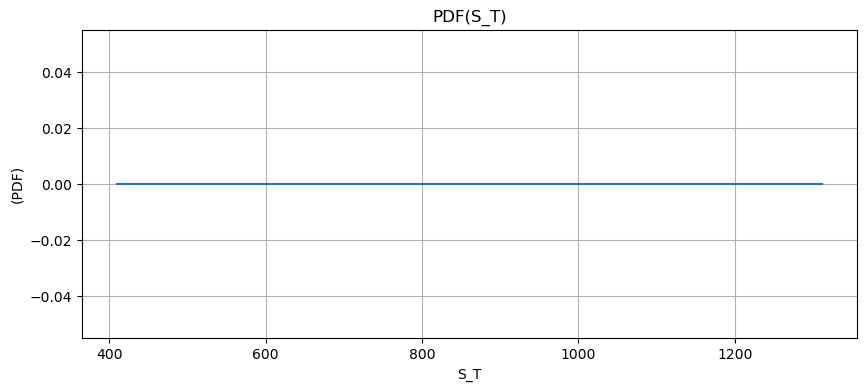

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df_pdf['S_T'], df_pdf['PDF'])
plt.title("PDF(S_T)")
plt.xlabel("S_T")
plt.ylabel("(PDF)")
plt.grid()
plt.show()

In [ ]:
area = df_pdf.query("S_T >= 750 and S_T <= 800")['PDF'].sum() * 0.01  # * step size
area

0.0

In [ ]:
strike = 730
atm_band = 10
step = 0.1
lower_bound = strike - atm_band
upper_bound = strike + atm_band
prob_atm = df_pdf.query(f"S_T >= {lower_bound} and S_T <= {upper_bound}")['PDF'].sum() * step

print(f"📈 ความน่าจะเป็นที่ Call OTM (strike 600) จะกลายเป็น ATM ภายใน 5 วัน: {prob_atm:.4%}")

📈 ความน่าจะเป็นที่ Call OTM (strike 600) จะกลายเป็น ATM ภายใน 5 วัน: 0.0000%


In [ ]:
strike = 500
atm_band = 10
step = 0.1
lower_bound = strike - atm_band
upper_bound = strike + atm_band
prob_atm = df_pdf.query(f"S_T >= {lower_bound} and S_T <= {upper_bound}")['PDF'].sum() * step

print(f"📈 ความน่าจะเป็นที่ Call OTM (strike 600) จะกลายเป็น ATM ภายใน 5 วัน: {prob_atm:.4%}")

📈 ความน่าจะเป็นที่ Call OTM (strike 600) จะกลายเป็น ATM ภายใน 5 วัน: 0.0000%
